## Запросы к базе данных с полетами

### Подключение к базе, структура данных

In [2]:
import psycopg2
import pandas as pd
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = psycopg2.connect(dbname = 'demo', user='postgres', 
                        password='1234', host='localhost')

In [4]:
cursor = conn.cursor()

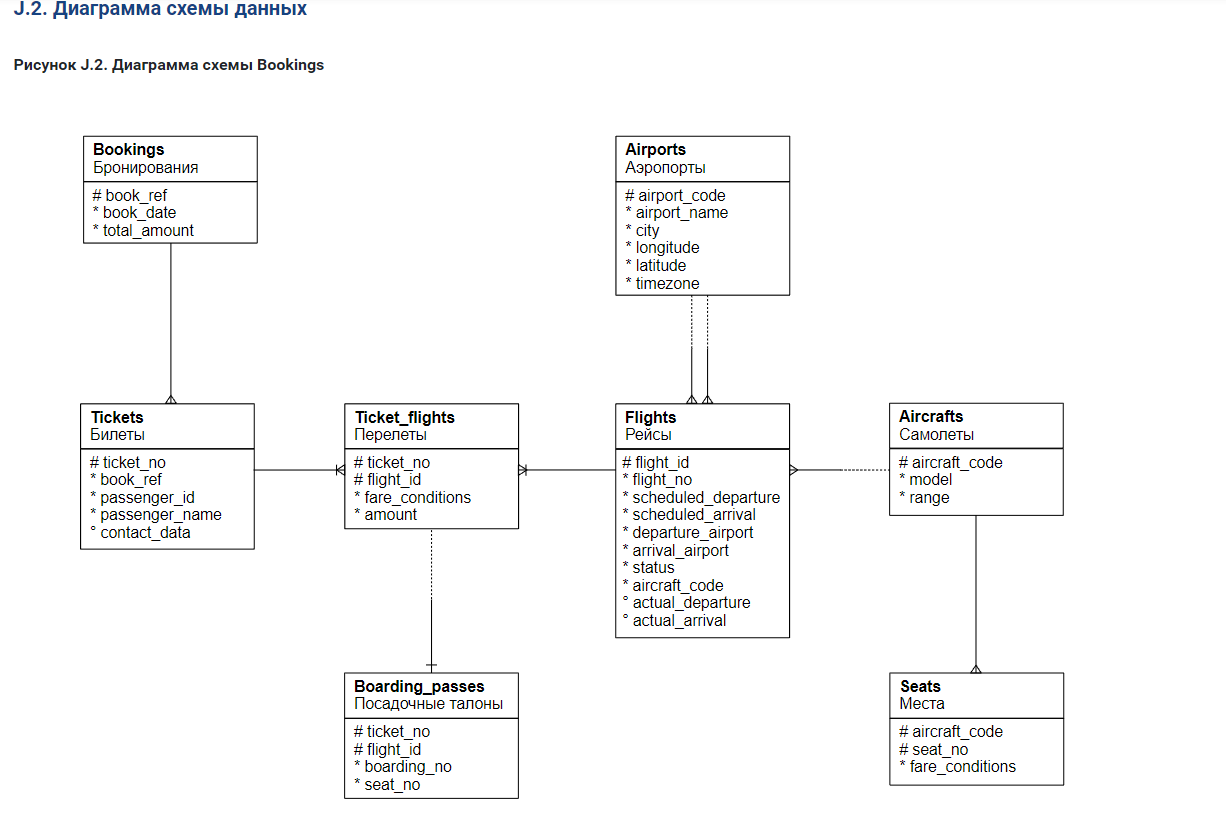

### 1. Посчитать заполняемость самолетов 

In [60]:
aircraft_fulfilment = """WITH 
                occupied AS ( 
                    SELECT flight_id, COUNT(seat_no) AS occupied_seats
                    FROM Boarding_passes 
                    GROUP BY flight_id),
                available AS (
                    SELECT aircraft_code, COUNT(seat_no) AS available_seats
                    FROM Seats 
                    GROUP BY aircraft_code)
                SELECT flight_id, aircraft_code, 
                    dep.city AS departure_city, arr.city AS arrival_city,
                    occupied_seats, available_seats, 100 * occupied_seats / available_seats AS occupation_rate
                FROM available 
                    INNER JOIN Flights USING(aircraft_code)
                    INNER JOIN occupied USING(flight_id)
                    INNER JOIN Airports dep ON Flights.departure_airport=dep.airport_code 
                    INNER JOIN Airports arr ON Flights.arrival_airport=arr.airport_code 
                """

In [61]:
df = pd.read_sql_query(aircraft_fulfilment, con = conn)

In [64]:
df

,flight_id,aircraft_code,departure_city,arrival_city,occupied_seats,available_seats,occupation_rate
0,1,321,Москва,Санкт-Петербург,79,170,46
1,2,321,Москва,Санкт-Петербург,101,170,59
2,3,321,Москва,Санкт-Петербург,97,170,57
3,17,321,Москва,Санкт-Петербург,101,170,59
4,18,321,Москва,Санкт-Петербург,96,170,56
...,...,...,...,...,...,...,...
11513,33115,CR2,Саранск,Москва,20,50,40
11514,33116,CR2,Саранск,Москва,17,50,34
11515,33117,CR2,Саранск,Москва,16,50,32
11516,33118,CR2,Саранск,Москва,16,50,32


In [53]:
df.shape

(11518, 6)

In [54]:
# unique flight_id
df.flight_id.nunique()

11518

<AxesSubplot:xlabel='aircraft_code', ylabel='occupation_rate'>

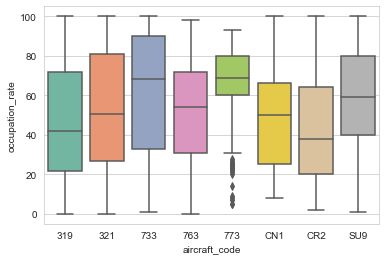

In [47]:
# распределение процента заполняемости по разным моделям самолетов
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.boxplot(x='aircraft_code', y='occupation_rate', data = df)

In [56]:
# количество полетов по городам вылета
df.groupby(by='departure_city', as_index=False)['flight_id'].count().sort_values('flight_id', ascending=False)

,departure_city,flight_id
38,Москва,3358
63,Санкт-Петербург,658
49,Новосибирск,332
57,Пермь,239
19,Екатеринбург,226
...,...,...
86,Череповец,7
1,Анадырь,5
69,Стрежевой,5
17,Горно-Алтайск,3


In [70]:
# заполняемость полетов из Москвы по городам прибытия
df[df.departure_city=='Москва'].groupby(by='arrival_city', as_index=False)['occupation_rate'].mean() \
                                .sort_values('occupation_rate', ascending=False)

,arrival_city,occupation_rate
39,Нижний Новгород,86.516129
69,Хабаровск,83.533333
63,Тюмень,81.903226
35,Нарьян-Мар,80.500000
2,Анапа,79.580645
...,...,...
27,Курск,19.870968
52,Салехард,19.096774
64,Улан-Удэ,13.538462
10,Владивосток,13.129032


### 2. В какие города полеты из Москвы в среднем заполняются меньше чем на 60%

In [83]:
low_occupation = """WITH 
            occupied AS ( 
                SELECT flight_id, COUNT(seat_no) AS occupied_seats
                FROM Boarding_passes 
                    INNER JOIN Flights USING(flight_id)
                    INNER JOIN Airports ON Flights.departure_airport=Airports.airport_code  
                WHERE city='Москва'
                GROUP BY flight_id), -- только рейсы из Москвы
            available AS (
                SELECT aircraft_code, COUNT(seat_no) AS available_seats
                FROM Seats 
                GROUP BY aircraft_code) -- находим сколько всего мест в каждой модели самолета
            SELECT  
                arr.city AS arrival_city, aircraft_code, 
                AVG(occupied_seats) AS average_occ_seats, AVG(available_seats) AS available_seats,
                100 * SUM(occupied_seats) / SUM(available_seats) AS occupation_rate
            FROM occupied 
                INNER JOIN Flights USING(flight_id)
                INNER JOIN available USING(aircraft_code)
                INNER JOIN Airports dep ON Flights.departure_airport=dep.airport_code 
                INNER JOIN Airports arr ON Flights.arrival_airport=arr.airport_code 
            GROUP BY arr.city, aircraft_code -- среднюю заполняемость самолета считаем на агрегированном уровне Город прибытия - Модель самолета
            HAVING 100 * SUM(occupied_seats) / SUM(available_seats) < 60 -- полеты только  в те города и на тех самолетах, где заполняемость ниже 60%
            ORDER BY occupation_rate DESC
                    """

In [84]:
df = pd.read_sql_query(low_occupation, con = conn)

In [85]:
df

,arrival_city,aircraft_code,average_occ_seats,available_seats,occupation_rate
0,Новый Уренгой,SU9,57.887097,97.0,59.677419
1,Элиста,SU9,57.709677,97.0,59.494513
2,Самара,763,128.258065,222.0,57.773903
3,Курган,CR2,28.648148,50.0,57.296296
4,Советский,SU9,55.516129,97.0,57.233123
5,Санкт-Петербург,321,97.070093,170.0,57.100055
6,Абакан,319,65.888889,116.0,56.800766
7,Киров,CN1,6.709677,12.0,55.913978
8,Ноябрьск,CR2,27.272727,50.0,54.545455
9,Брянск,SU9,52.613333,97.0,54.240550


In [ ]:
# возможно в какие-то города можно заменить самолеты с меньшей общей вместимостью, 
# если это позволяют технические возможности самолета
# возможно на дальние рейсы во Владивосток и Петропавловск-Камчатский может летать только 763 модель и ее невозможно заменить